# ML - Fall 2023 - Practical 5

## Decision Trees

Student Name: Parham Rezaei

Student Number: 400108547

In [1]:
! pip install optuna
! pip install catboost
! pip install gdown



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.5 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.6 MB/s eta 0:00:00










     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00








     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.0 MB/s eta 0:00:00

































In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
!gdown 'https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr'

Downloading...

From: https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr

To: /content/train.csv

100% 170k/170k [00:00<00:00, 85.0MB/s]


# P1: Explore (13 points)

Load the dataset as a dataframe

In [10]:
df = pd.read_csv('train.csv')

Inspect the first rows of the dataframe **(P1-1: 1 point)**

In [11]:
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1,1883,...,2,80,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1,1585,...,1,80,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1,1478,...,4,80,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1,1965,...,1,80,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,1,722,...,4,80,0,10,2,2,10,7,0,8


Calculate the number of samples **(P1-2: 0.5 point)**

In [12]:
len(df)

1102

In [13]:
len(df[df.duplicated()])

0

Measure the number of unique values for each column. Note that `Attrition` is the target column. **(P1-3: 1.5 points)**

In [14]:
df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    736
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1102
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1027
MonthlyRate                 1082
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

Check if there is a column with less than two unique values. If such a columns exists, remove it! **(P1-4: 1.5 points)**

In [15]:
print(df.columns[df.nunique() < 2])
df.drop(columns=df.columns[df.nunique() < 2], inplace=True)

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')


Plot Mean `BusinessTravel` against `Age`. Note: Since the `BusinessTravel` column is categorical, you should first consider another column corresponding to each unique value `BusinessTravel` takes. For instance, you may assume that if someone does not travel, the value of the column for this person is 0. **(P1-5: 2.5 points)**

In [16]:
# handle uniqueness
print(df['BusinessTravel'].unique())
print(df['BusinessTravel'].value_counts())

['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Travel_Rarely        783

Travel_Frequently    213

Non-Travel           106

Name: BusinessTravel, dtype: int64


In [17]:
# Map the column
df['BusinessTravel_numeric'] = df['BusinessTravel'].map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})

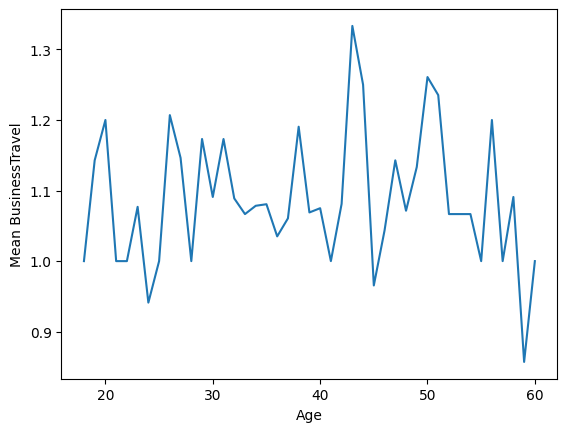

In [19]:
# plot
mab = df.groupby('Age')['BusinessTravel_numeric'].mean()
plt.plot(mab.index, mab.values)
plt.xlabel('Age')
plt.ylabel('Mean BusinessTravel')
plt.show()

Find the `Department` in which the least amount of time has passed since the last promotion of the employees on average. **(P1-6: 1 point)**

In [21]:
x = df.groupby('Department')['YearsSinceLastPromotion'].mean().sort_values()
print(x.sort_values())
print(f"The min department is {x.idxmin()}")

Department

Human Resources           1.711111

Research & Development    2.088766

Sales                     2.244048

Name: YearsSinceLastPromotion, dtype: float64

The min department is Human Resources


Check if there seems to be a meaningful relationship between people's age and the years they have worked with their current manager. Your result should be a plot. **(P1-7: 2 points)**

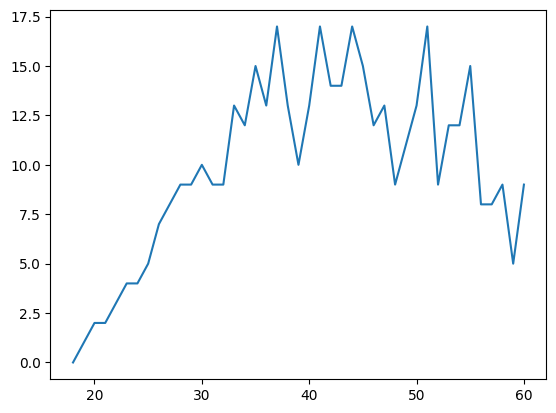

In [22]:
x = df.groupby('Age')['YearsWithCurrManager'].max()
plt.plot(x)

We see that the starting age the can work is around 20 so if the age is x our max worked is atmost x-20

Also the longest working with current manager employees are around 40-50 years old with around 17.5 years which 

can be when the manager was chosen or ...


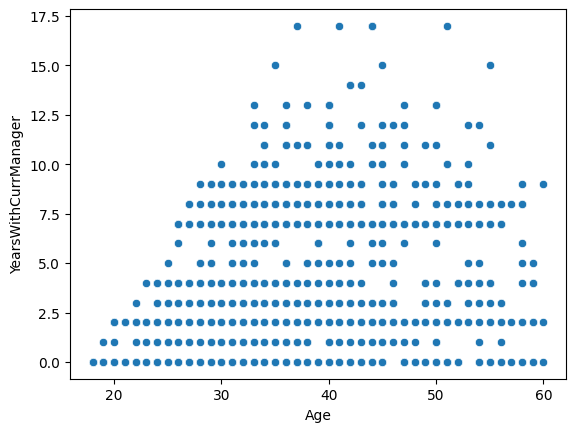

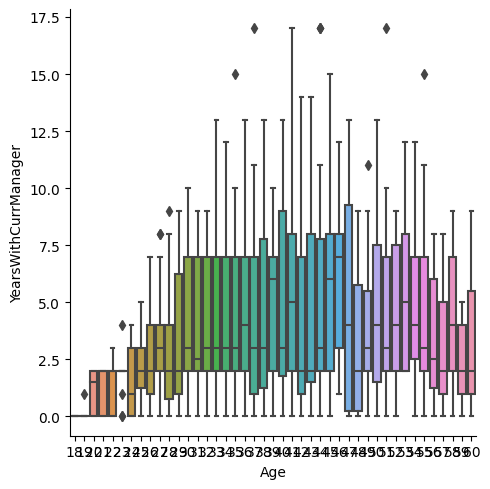

In [23]:
sns.scatterplot(x='Age', y='YearsWithCurrManager', data=df)
sns.catplot(x='Age', y='YearsWithCurrManager', data=df, kind='box')
print("We see that the starting age the can work is around 20 so if the age is x our max worked is atmost x-20")
print("Also the longest working with current manager employees are around 40-50 years old with around 17.5 years which \n\
can be when the manager was chosen or ...")

Compare the average `JobSatisfaction` for employees whose `JobRole` is `Research Scientist`, `Human Resources`, `Manager`, or `Research Director` using a plot.  **(P1-8: 2 points)**

JobRole

Human Resources              2.594595

Research Director            2.609375

Laboratory Technician        2.632124

Sales Representative         2.690141

Manager                      2.702703

Healthcare Representative    2.724490

Sales Executive              2.780591

Research Scientist           2.784141

Manufacturing Director       2.792079

Name: JobSatisfaction, dtype: float64

check next cell too


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Research Director'),
  Text(1, 0, 'Research Scientist'),
  Text(2, 0, 'Human Resources'),
  Text(3, 0, 'Manager')])

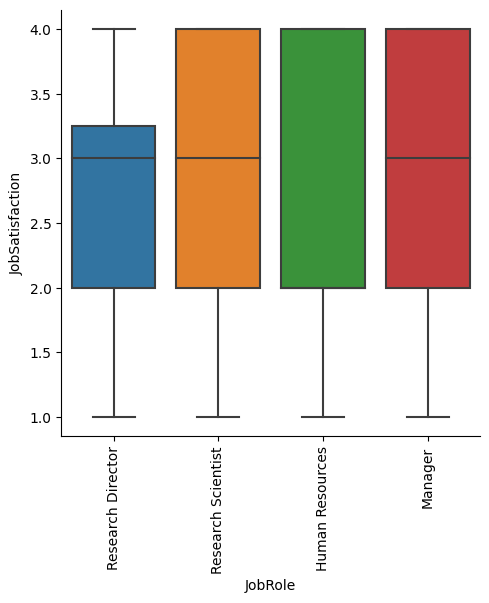

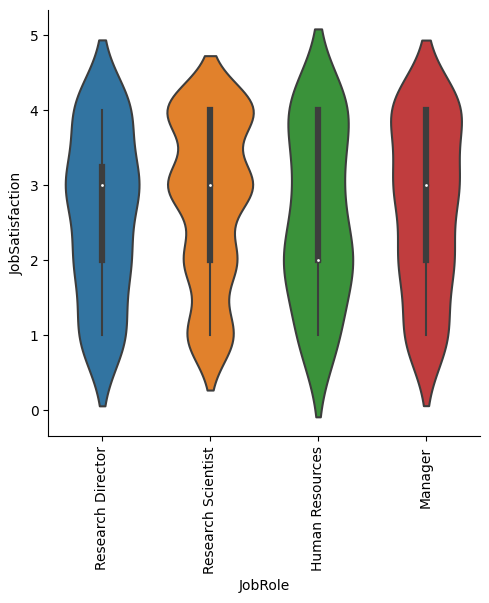

In [24]:
print(df.groupby('JobRole')['JobSatisfaction'].mean().sort_values())
print("check next cell too")
JobRoleConstrained = df.loc[df['JobRole'].isin(['Research Scientist', 'Human Resources', 'Manager', 'Research Director'])]
sns.catplot(x='JobRole', y='JobSatisfaction', data=JobRoleConstrained, kind='box')
plt.xticks(rotation=90)
sns.catplot(x='JobRole', y='JobSatisfaction', data=JobRoleConstrained, kind='violin')
plt.xticks(rotation=90)

Text(0.5, 0, 'JobRole')

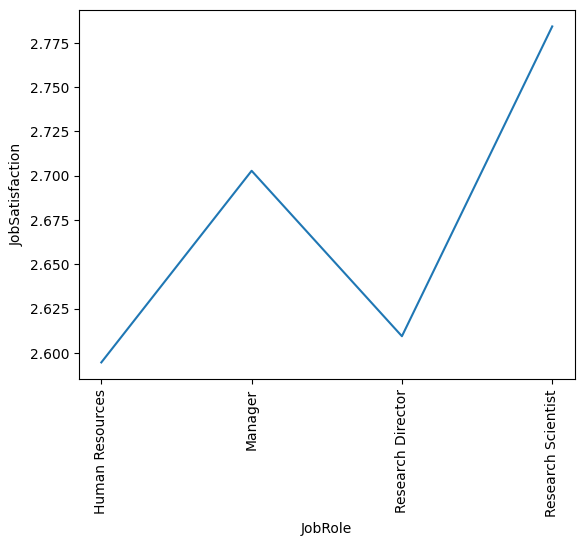

In [25]:
x = df.loc[df['JobRole'].isin(['Research Scientist', 'Human Resources', 'Manager', 'Research Director'])]
x = x.groupby('JobRole')['JobSatisfaction'].mean()
sns.lineplot(x=x.index, y=x.values)
plt.xticks(rotation=90)
plt.ylabel('JobSatisfaction')
plt.xlabel('JobRole')

Plot the average `MonthlyIncome` against the `YearsAtCompany`. **(P1-9: 1 point)**

Text(0.5, 0, 'Years at Company')

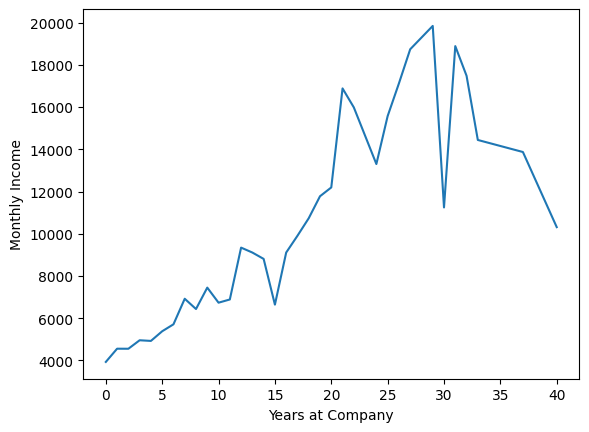

In [26]:
x = df.groupby('YearsAtCompany')['MonthlyIncome'].mean()
sns.lineplot(x=x.index, y=x.values)
plt.ylabel('Monthly Income')
plt.xlabel('Years at Company')

# P2: Pre-processing (9 points)

Label encode all categorical columns and split the data into train and test parts. The training part will further splitted into train and validation parts. **(P2-1: 2.5 points)**

In [27]:
# Label encode  (1.5 points)
from sklearn.preprocessing import LabelEncoder
columns = df.columns[df.dtypes == 'object']
for column in columns:
    df[column] = LabelEncoder().fit_transform(df[column])
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_numeric
0,29,0,2,592,1,7,3,1,1883,4,...,2,0,11,2,3,3,2,1,2,1
1,36,0,2,884,2,1,4,1,1585,2,...,1,0,15,5,3,1,0,0,0,1
2,34,0,2,1326,2,3,3,4,1478,4,...,4,0,15,2,3,13,9,3,12,1
3,27,0,2,954,2,9,3,2,1965,4,...,1,0,7,5,3,7,7,0,7,1
4,32,0,2,929,2,10,3,2,722,4,...,4,0,10,2,2,10,7,0,8,1


In [31]:
# split into train and validation (0.5 point)
from sklearn.model_selection import train_test_split
df_train, df_vt = train_test_split(df,test_size=0.2,random_state=34,shuffle=True)

In [32]:
# lens of train and validation datasets (0.5 point)
print(f"len training data: {len(df_train)}")
print(f"len validation data: {len(df_vt)}")

len training data: 881

len validation data: 221


Further split the test dataframe into validation and test dataframes. **(P2-2: 0.5 point)**

In [33]:
df_val, df_test = train_test_split(df_vt, test_size=0.5, random_state=0)
print(len(df_val))
print(len(df_test))

110

111


Split the test and validation dataframe into feature and label part, Attrition columns is the target columns and rest of the columns should be treated as features. **(P2-3: 1 point)**

In [34]:
y_test = df_test['Attrition']
X_test = df_test.drop(columns=['Attrition'])

y_val = df_val['Attrition']
X_val = df_val.drop(columns=['Attrition'])

check if the training dataset is label balanced. **(P2-4: 2 points)**

In [39]:
X_train = df_train.drop(columns=['Attrition'])
y_train = df_train['Attrition']
vc = y_train.value_counts()
print(vc)
if vc[0]/vc[1] > 2 or vc[1]/vc[0] > 2:
  print("It is imbalanced")
else:
  print("~ balanced")

0    722

1    159

Name: Attrition, dtype: int64

It is imbalanced


Balance the training dataset by oversampling the class with less samples. **(P2-5: 2 points)**

Don't know oversampling? Read [this link](https://deeptip.ir/oversampling-and-undersampling-in-python/) (5 minutes)

In [40]:
# oversampling (1.5 points)
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_oversample, y_train_oversample = oversample.fit_resample(X_train, y_train)

In [41]:
# check if dataset is balanced (0.5 point)
vc = y_train_oversample.value_counts()
print(vc)
if vc[0]/vc[1] > 2 or vc[1]/vc[0] > 2:
  print("It is imbalanced")
else:
  print("~ balanced")

0    722

1    722

Name: Attrition, dtype: int64

~ balanced


Split the training dataframe into feature and target columns. **(P2-6: 1 point)**

In [42]:
# done in 3 cells above
X_train = X_train_oversample
y_train = y_train_oversample

# P3: Decision tree from scratch (20 points)
Don't know Decision Tree? Read [this link](https://betterdatascience.com/mml-decision-trees/) (25 minutes).

Watch an introduction to Decision Trees [here](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&list=PLblh5JKOoLUIE96dI3U7oxHaCAbZgfhHk) (10 minutes).

Implement decision tree based on the given functions. **(P3-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [44]:
class DecisionTree:

    def __init__(self, max_depth=None, max_features=None, random_state=0):
        self.max_depth = max_depth
        self.max_features = max_features # this will be used later in the RandomForest class
        np.random_state = random_state
        self.tree = {}

    def _compute_entropy(self, y):
        _, y_counts = np.unique(y, return_counts=True)
        y_probs = y_counts/np.sum(y_counts)
        ent = 0
        for t in y_probs:
          if t==0:
            continue
          ent += -t*np.log2(t)
        return ent

    def _split_data(self, X, y, feature_index, threshold):
        lower_ind = np.where(X[:,feature_index] <= threshold)
        higher_ind = np.where(X[:, feature_index] > threshold)
        return X[lower_ind], X[higher_ind], y[lower_ind], y[higher_ind]

    def _find_best_split(self, X, y):
        n_features = X.shape[1]
        best_feature_index = 0
        best_threshold = 0
        min_entropy = self._compute_entropy(y)
        feature_indices = range(n_features)
        if self.max_features is not None:
            feature_indices = np.random.choice(feature_indices, size=self.max_features, replace=False)
        for feature_index in feature_indices:
            values = sorted(np.unique(X[:, feature_index]))

            for val_ind in range(len(values)-1):
                threshold = np.mean([values[val_ind], values[val_ind+1]])
                left_X,right_X,left_y,right_y = self._split_data(X, y, feature_index, threshold)
                if len(left_X)==0 or len(right_X)==0:
                    continue
                entropy = self._compute_entropy(left_y)*len(left_X)/len(X) +\
                      self._compute_entropy(right_y)*len(right_X)/len(X)
                if min_entropy > entropy:
                    best_feature_index = feature_index
                    best_threshold = threshold
                    min_entropy = entropy
        leaf = False
        if min_entropy == 0:
            leaf = True
        return best_feature_index, best_threshold, min_entropy, leaf


    def _build_tree(self, X, y, depth):
        treeNode = {}
        treeNode['majorChoice'] = np.bincount(y).argmax()
        if self.max_depth is not None and depth >= self.max_depth:
            return treeNode
        if self._compute_entropy(y) == 0:
            return treeNode
        feature_index, threshold, entropy, leaf = self._find_best_split(X,y)

        if leaf:return treeNode
        treeNode['majorChoice'] = -1
        left_X,right_X,left_y,right_y = self._split_data(X,y,feature_index,threshold)
        treeNode['entropy'] = entropy
        treeNode['feature_index'] = feature_index
        treeNode['threshold'] = threshold
        treeNode['lower'] = self._build_tree(left_X,left_y,depth+1)
        treeNode['higher'] = self._build_tree(right_X,right_y,depth+1)
        return treeNode


    def fit(self, X, y):
        self.tree = self._build_tree(X,y,0)

    def _predict_sample(self, x, tree):
        if not tree:
            return None
        if tree['majorChoice'] != -1:
            return tree['majorChoice']
        if x[tree['feature_index']] <= tree['threshold']:
            return self._predict_sample(x,tree['lower'])
        else:
            return self._predict_sample(x,tree['higher'])

    def predict(self, X):
        return np.array([self._predict_sample(x,self.tree) for x in X])

Define the model and train it. **(P3-2: 1 point)**

In [45]:
my_dtc = DecisionTree(max_depth=3)
my_dtc.fit(X_train.to_numpy(), y_train.to_numpy())

Predict the y_train and y_val values. **(P3-3: 1 point)**

In [46]:
y_train_pred = my_dtc.predict(X_train.to_numpy())
y_val_pred = my_dtc.predict(X_val.to_numpy())

In [47]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.7610803324099723,       0.7727272727272727

Train and validation recall are: 0.7770083102493075,       0.7058823529411765

Train and validation f1 are: 0.7648261758691206,       0.48979591836734687


Visulize (y_train, y_train_pred) using Heatmap **(P3-4: 1.5 points)**

<Axes: >

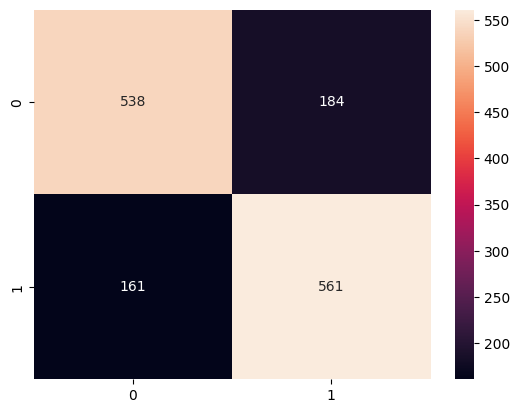

In [48]:
# src: https://www.geeksforgeeks.org/seaborn-heatmap-a-comprehensive-guide/ (6 minutes)
# src: https://blog.faradars.org/confusion-matrix-from-zero-to-hero/ (5 minutes)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d')

Visulize (y_val, y_val_pred) using Heatmap **(P3-5: 1.5 points)**

<Axes: >

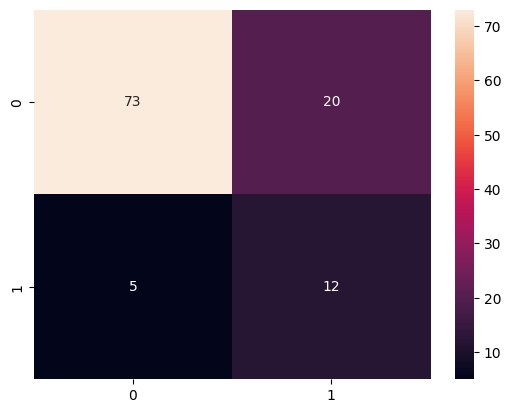

In [49]:
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d')

# P4: Random forest from scratch (20 points)
Don't know Random Forest? Read [this link](https://quera.org/blog/random-forest-algorithm/) (15 minutes).

Implement Random Forest based on the given functions. **(P4-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [50]:
class RandomForest:
    def __init__(self, num_trees=10, max_depth=None, random_state=None, max_features=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        for i in range(self.num_trees):
            tree = DecisionTree(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            indices = np.random.choice(range(len(X)), size=len(X), replace=True)
            X_sample = X[indices,:]
            y_sample = y[indices]
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        y_preds = np.array([tree.predict(X) for tree in self.trees])
        y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=y_preds)
        return y_pred

Define the model and train it. **(P4-2: 1 point)**

In [63]:
model = RandomForest(max_depth=5, num_trees=20,random_state=34, max_features = 6)#max features around sqrt
model.fit(X_train.to_numpy(), y_train.to_numpy())

Predict the y_train and y_val values. **(P4-3: 1 point)**

In [64]:
y_train_pred = model.predict(X_train.to_numpy())
y_val_pred = model.predict(X_val.to_numpy())

In [65]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.8580332409972299,       0.8363636363636363

Train and validation recall are: 0.8227146814404432,       0.5294117647058824

Train and validation f1 are: 0.8528356066044508,       0.5


Visulize (y_train, y_train_pred) using Heatmap **(P4-4: 1.5 points)**

<Axes: >

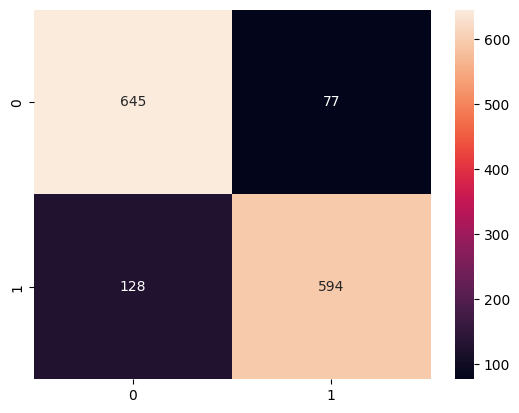

In [66]:
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d')

Visulize (y_val, y_val_pred) using Heatmap **(P4-5: 1.5 points)**

<Axes: >

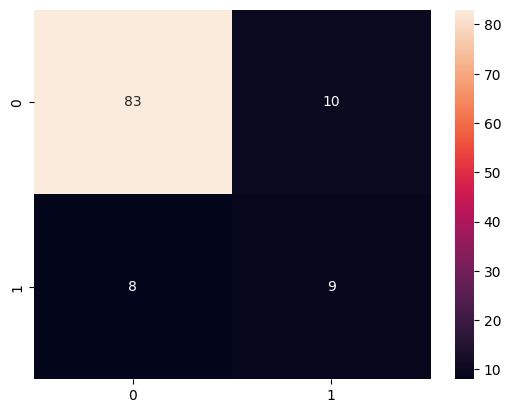

In [67]:
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d')

# P5: Decision Tree (10 points)

Fit the data to a decision tree (of sklearn) with maximum depth of 2. **(P5-1: 2 points)**

In [68]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

Plot the fitted decision tree. **(P5-2: 2 points)**

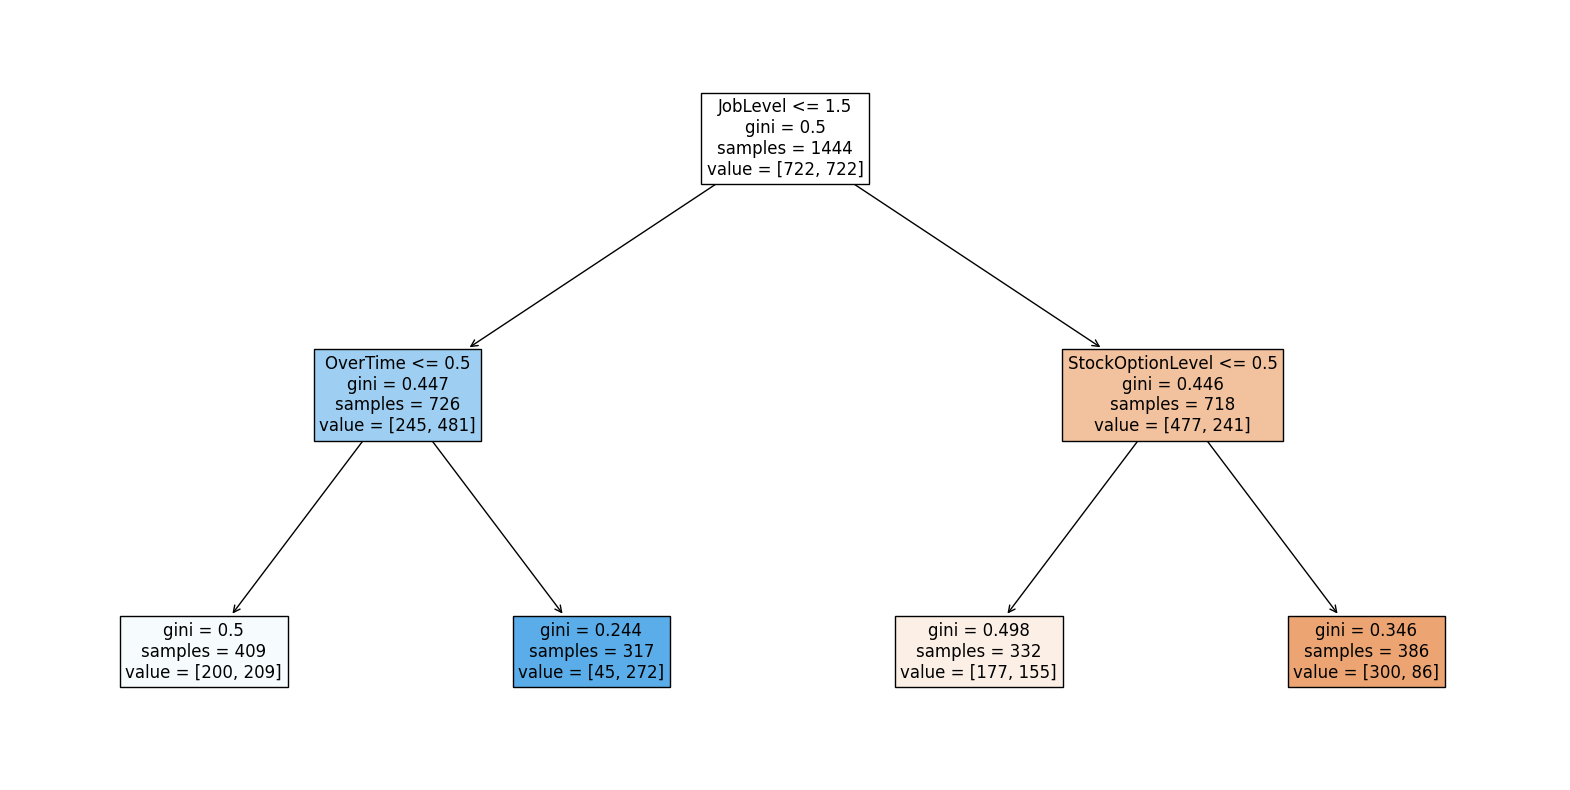

In [69]:
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_train.columns, filled=True, fontsize=12)
plt.show()

Make predictions on training and validation set and calculate accuracy, recall and f1_score on them. **(P5-3: 1 point)**

In [70]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

In [71]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.6634349030470914,       0.6636363636363637

Train and validation recall are: 0.6662049861495845,       0.5294117647058824

Train and validation f1 are: 0.664364640883978,       0.3272727272727273


Plot the confusion matrices for the training and validation datasets. **(P5-4: 2 points)**

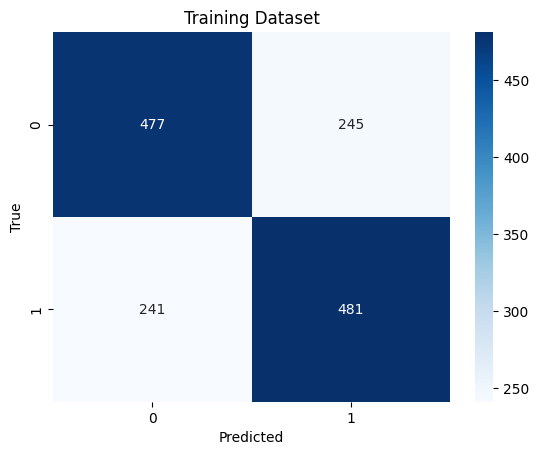

In [72]:
# 1 point for (y_train, y_train_pred)
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Training Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

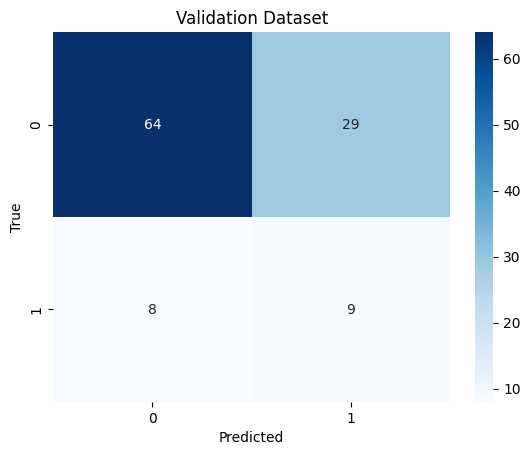

In [73]:
# 1 point for (y_val, y_val_pred)
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Experiment with different depth trees and plot the f1_score associated with each depth on training and valication datasets. **(P5-5: 3 points)**

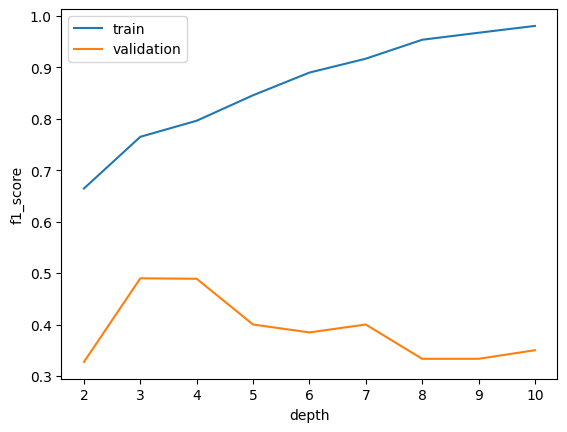

In [75]:
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores = []
val_scores = []
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, criterion='gini')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    train_scores.append(f1_score(y_train, y_train_pred))
    val_scores.append(f1_score(y_val, y_val_pred))

plt.plot(depths, train_scores, label='train')
plt.plot(depths, val_scores, label='validation')
plt.xlabel('depth')
plt.ylabel('f1_score')
plt.legend()
plt.show()

# P6: Random Forest (7 points)

Fit the training data to a random forest (of sklearn). **(P6-1: 2 points)**

In [78]:
skRF = RandomForestClassifier(criterion='gini')
skRF.fit(X_train, y_train)

RandomForestClassifier()

Plot the feature importances using a bar plot. **(P6-2: 2 points)**

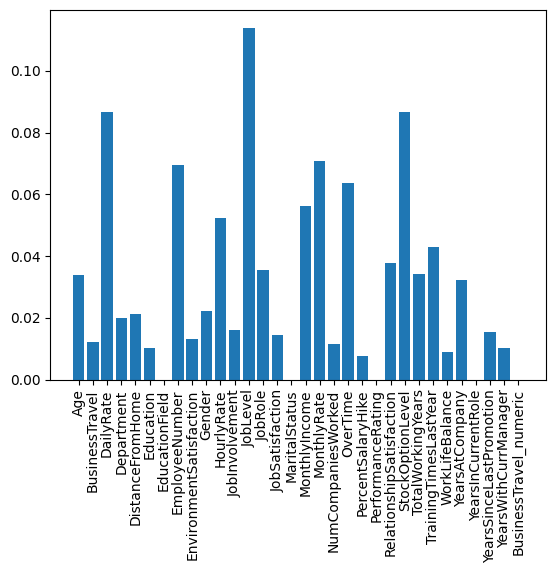

In [79]:
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P6-3: 1 point)**

In [80]:
y_train_pred = skRF.predict(X_train)
y_val_pred = skRF.predict(X_val)

In [81]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 1.0,       0.8727272727272727

Train and validation recall are: 1.0,       0.4117647058823529

Train and validation f1 are: 1.0,       0.5


Plot the confusion matrices for the training and validation datasets. **(P6-4: 2 points)**

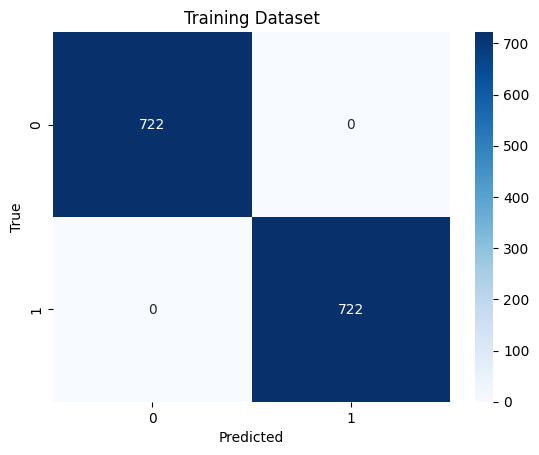

In [82]:
# 1 point for (y_train, y_train_pred)
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Training Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

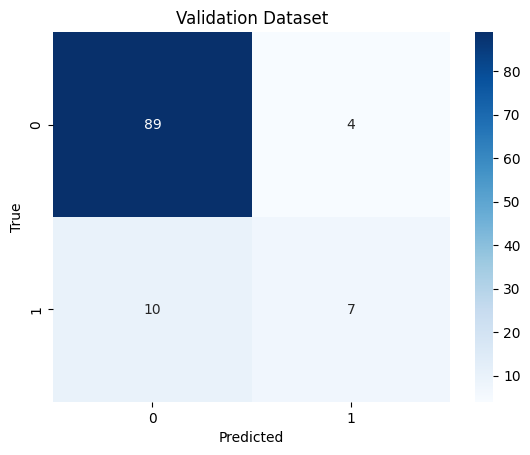

In [83]:
# 1 point for (y_val, y_val_pred)
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# P7: Gradient Boosted Decision Trees (5 points)
Don't know GBD Tree? Follow [this link](https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/) (+30 minutes).

Fit a gradient boosted decision tree(e.g. catboost, lightgbm, xgboost). **(P7-1: 2 points)**

Using the catboost library is recommended

In [84]:
catModel = CatBoostClassifier(verbose=0)
catModel.fit(X_train, y_train)

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P7-2: 1 point)**

In [85]:
y_train_pred = catModel.predict(X_train)
y_val_pred = catModel.predict(X_val)

In [86]:
print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 1.0,       0.8727272727272727

Train and test recall are: 1.0,       0.4117647058823529

Train and test f1 are: 1.0,       0.5


Plot the confusion matrices for the training and validation datasets. **(P7-3: 2 points)**

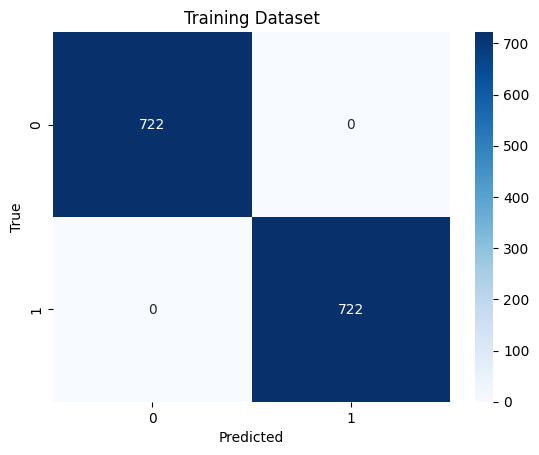

In [87]:
# 1 point for (y_train, y_train_pred)
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Training Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

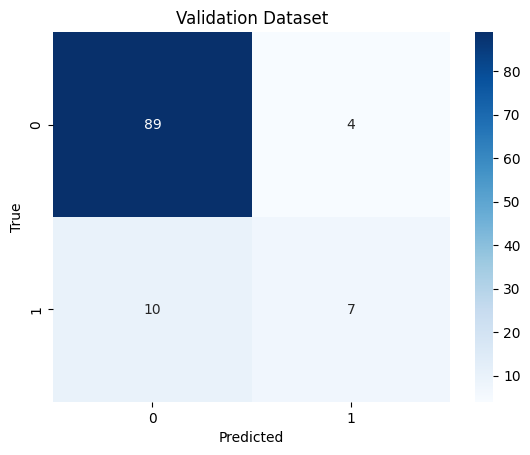

In [88]:
# 1 point for (y_val, y_val_pred)
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# P8: Tuning parameters using optuna? (12 points)

There are many tunable parameters in Gradient boosted decision trees tuning all of them using grid search is almost impossible. There is no other choice for tuing hyperparameters unless you assume some models on behaviour of models under different hyperparameter choices e.g. the follow a gaussian process. Use the optuna library to tune the hyperparameters of gradient boosted decision tree. Report the results as in the previous parts. **(P8-1: 10 points)**

Do you want to get familiar more with it? Follow [this link](https://datagy.io/python-optuna/) (+40 minutes)

Do you know the difference between parameters and hyperparameters? If no, you can find more [here](https://virgool.io/@maryam.hasanali/%D9%87%D8%A7%DB%8C%D9%BE%D8%B1%D9%BE%D8%A7%D8%B1%D8%A7%D9%85%D8%AA%D8%B1%D9%87%D8%A7%DB%8C-%D8%AF%D8%B1-%DB%8C%DA%A9-%D9%85%D8%AF%D9%84-%DB%8C%D8%A7%D8%AF%DA%AF%DB%8C%D8%B1%DB%8C-%D9%85%D8%A7%D8%B4%DB%8C%D9%86-%DA%86%DB%8C%D8%B3%D8%AA-%D9%88-%DA%86%DA%AF%D9%88%D9%86%D9%87-%D8%A2%D9%86-%D8%B1%D8%A7-%D8%AA%D9%86%D8%B8%DB%8C%D9%85-%DA%A9%D9%86%DB%8C%D9%85-o8zgjoouhwen) (3 minutes).

In [89]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'random_state': 0,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    return f1_score(y_val, y_val_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial = study.best_trial
trial.params

[I 2024-01-07 20:27:41,655] A new study created in memory with name: no-name-db126da1-c869-4680-8610-d68ec98bc744

[I 2024-01-07 20:27:41,800] Trial 0 finished with value: 0.4888888888888888 and parameters: {'n_estimators': 68, 'max_depth': 4, 'learning_rate': 0.007282735930041879}. Best is trial 0 with value: 0.4888888888888888.

[I 2024-01-07 20:27:41,897] Trial 1 finished with value: 0.6111111111111113 and parameters: {'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.055131838058139086}. Best is trial 1 with value: 0.6111111111111113.

[I 2024-01-07 20:27:41,970] Trial 2 finished with value: 0.5238095238095238 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.018831508992195708}. Best is trial 1 with value: 0.6111111111111113.

[I 2024-01-07 20:27:42,024] Trial 3 finished with value: 0.4782608695652174 and parameters: {'n_estimators': 20, 'max_depth': 2, 'learning_rate': 0.08175743780305673}. Best is trial 1 with value: 0.6111111111111113.

[I 2024-01-07 

{'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.055131838058139086}

In [90]:
model = CatBoostClassifier(**trial.params, verbose=False)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 0.871191135734072,       0.8727272727272727

Train and test recall are: 0.8628808864265928,       0.6470588235294118

Train and test f1 are: 0.8701117318435754,       0.6111111111111113


Plot the confusion matrices for the training and validation datasets. **(P8-2: 2 points)**

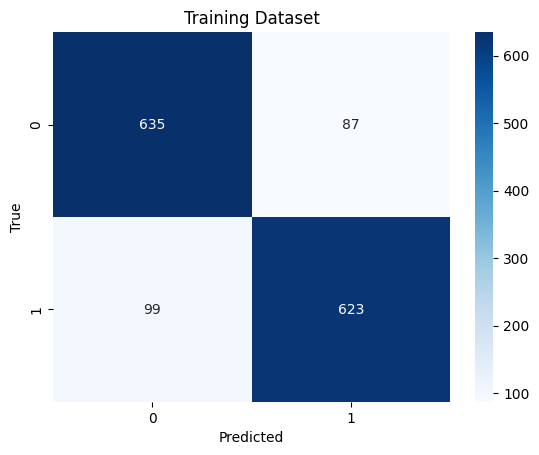

In [91]:
# 1 point for (y_train, y_train_pred)
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Training Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

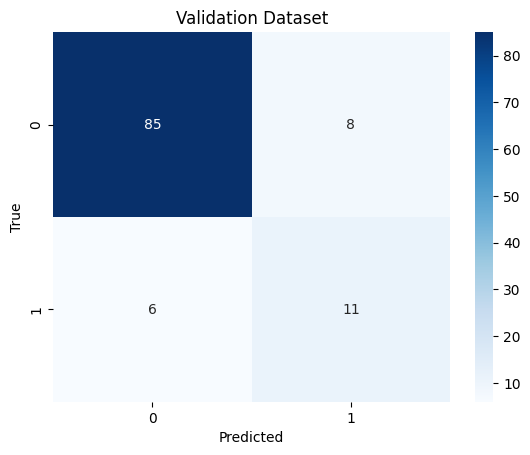

In [92]:
# 1 point for (y_val, y_val_pred)
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# P9: Performance on testing data (4 points)

call the model on test data. **(P9-1: 1 point)**

In [93]:
y_test_pred = model.predict(X_test)

evaluate your model on the testing data using f1_score. **(P9-2: 1 point)**

In [94]:
print(f'Test f1 is: {f1_score(y_test, y_test_pred)}')

Test f1 is: 0.47368421052631576


What is the origin of loosing performance on the test set? Answer briefly here. **(P9-3: 1 point)**

** Because the parameters which we found were based on the validation data
so we used this part of the dataset for our final decision of the model and it is not a perfect resemblance of the true error which we faced in the test data f1. so the value decreased a bit **

</br>
Also one thing to notice is that the dataset is quite lopsided. having few class 1 samples therefor our validation and test datasets which we did not perform any oversampling method on it are not quite good representatives of the accuracy on the true distribution
</br>
One reason behind loosing performance generally on test set can be the model overfitting on our data. It results in poor generalization

Plot the heatmap of the confusion matrix here. **(P9-4: 1 point)**

<Axes: >

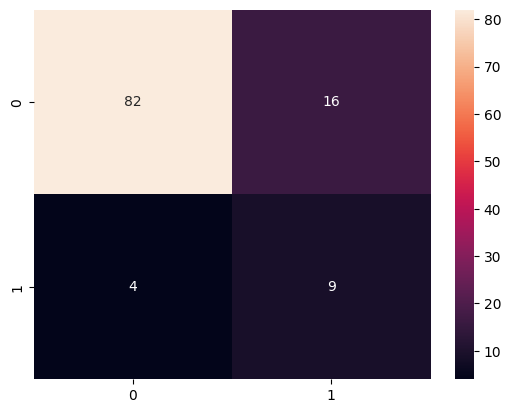

In [95]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d')